# **Sampta Experience I**

## Purpose
The goal of these experiments is to identify neural network configurations that minimize unwanted frequency artifacts while preserving the fidelity of signal reconstruction. We aim to explore how architectural choices, such as activation functions and embedding frequencies, influence the spectral properties of reconstructed signals.

## Experimental Setup

We generate a synthetic target signal on a sphere by creating a random combination of spherical harmonics of a fixed frequency \(L = 15\). The network is trained to learn this target signal on a coarse grid that is sufficiently dense to capture the \(L = 15\) harmonics accurately. After training, the network's performance is evaluated by analyzing the spectrum of the reconstructed signal on a fine grid with twice the resolution of the training grid. This approach allows us to identify whether the network introduces spurious high-frequency components, revealing potential artifacts in the reconstruction process.



We study the impact of specific aspect of the network’s architecture:
1. **Impact of Hidden Layer's Activations**
2. **Impact of First Layer's Activation**
3. **Impact of the Embedding Maximum Frequency ($L_0$)**

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch_harmonics as th
import spherical_inr as sph
from sklearn.preprocessing import MinMaxScaler

In [43]:
def compute_snr(image, noisy_image):
    """
    Computes the Signal-to-Noise Ratio (SNR) between two images.
    """
    
    signal_power = np.mean(np.square(image))
    noise_power = np.mean(np.square(image - noisy_image))
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

In [44]:
l_freq = 15
coeffs = np.random.randn(l_freq+1)

def create_composite_function(l_freq, coeffs):
    # Precompute harmonic functions weighted by coefficients
    components = []
    
    for m in range(-l_freq, l_freq + 1):
            coeff = coeffs[m]
            harmonic_func = sph.get_SH(m, l_freq)
            components.append(lambda theta, phi, c=coeff, f=harmonic_func: c * f(theta, phi))

    # Combine into a single function
    def composite_function(theta, phi):
        return sum(func(theta, phi) for func in components)

    return composite_function

f_target = create_composite_function(l_freq, coeffs)

In [45]:
### Coarse gird

L_coarse = 30
phi_coarse, theta_coarse, (nlon_coarse, nlat_coarse) = sph.sample_s2(L_coarse, sampling = "gl", torch_tensor = True)
sht_coarse = th.RealSHT(nlat=nlat_coarse, nlon=nlon_coarse, lmax=L_coarse, mmax=L_coarse, grid = "legendre-gauss")

X_coarse = torch.stack([theta_coarse.flatten(), phi_coarse.flatten()], axis=-1).float()
y_coarse = f_target(theta_coarse.flatten(), phi_coarse.flatten()).unsqueeze(1).float()

coeffs_coarse = sht_coarse(y_coarse.reshape(nlat_coarse, nlon_coarse)).numpy()

scaler = MinMaxScaler()
y_coarse = torch.tensor(scaler.fit_transform(y_coarse)).float()

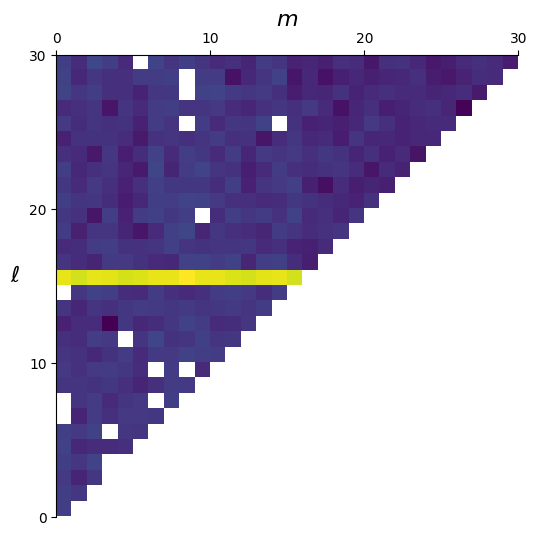

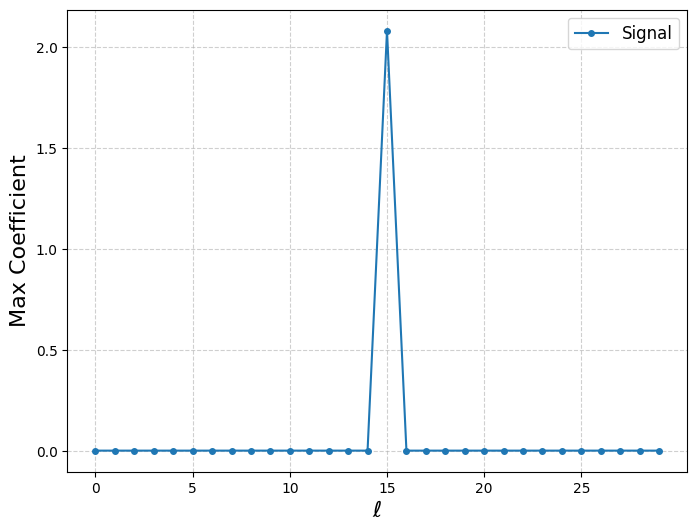

In [46]:
sph.plot_SHT_coeffs(coeffs_coarse)
sph.plot_max_SHT_coeffs(coeffs_coarse, ticks_l=5)
plt.show()

In [47]:
### Fine grid

L_fine = 60
phi_fine, theta_fine, (nlon_fine, nlat_fine) = sph.sample_s2(L_fine, sampling = "gl", torch_tensor = True)
sht_fine = th.RealSHT(nlat=nlat_fine, nlon=nlon_fine, lmax=L_fine, mmax=L_fine, grid = "legendre-gauss")

X_fine = torch.stack([theta_fine.flatten(), phi_fine.flatten()], dim=-1).float()
y_fine = f_target(theta_fine.flatten(), phi_fine.flatten()).unsqueeze(1).float()

coeffs_fine = sht_fine(y_fine.reshape(nlat_fine, nlon_fine)).numpy()

y_fine = torch.tensor(scaler.transform(y_fine)).float()

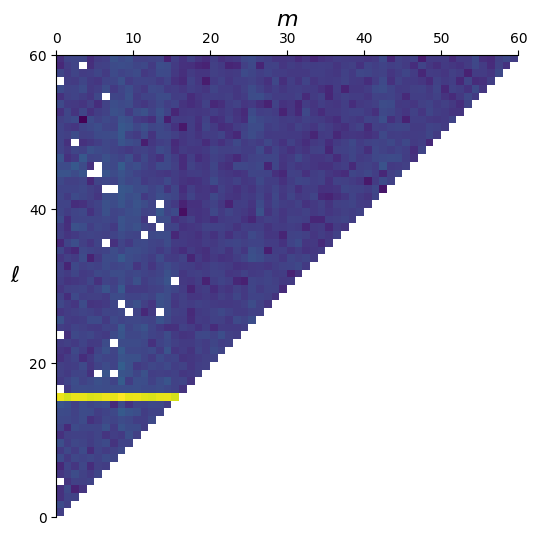

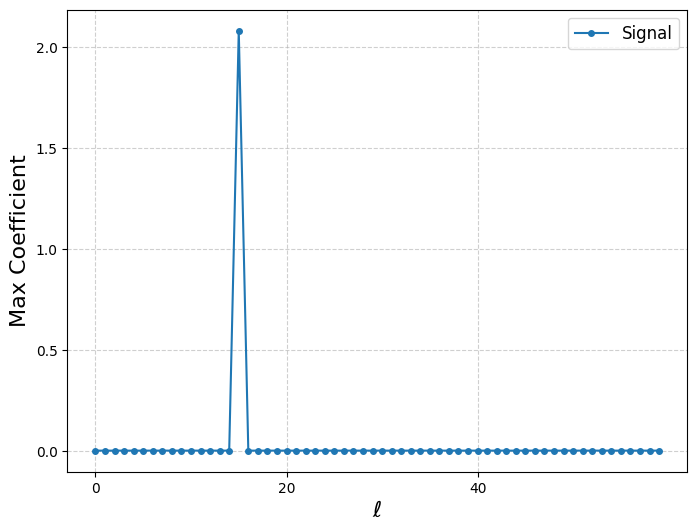

In [48]:
sph.plot_SHT_coeffs(coeffs_fine, ticks_l=20)
sph.plot_max_SHT_coeffs(coeffs_fine, ticks_l=20)
plt.show()

# **Experiences**

---
### a. Study of the Impact of Hidden Layer's Activations

This experiment investigates how the choice of <span style="color:blue"> **subsequent layers' activation functions** </span> influences the spectral properties of the reconstructed signals.


#### Parameters

**Note** : 
 * For the network with Tchebychev functions, the tuples in `activation_degrees` are define as : `(degree_first, degree_subseq)` where `degree_first` is first layer activation degree and `degree_subseq` the subsequent layers degree.

 * For the network with Tchebychev functions, the list `alphas` contains the equi-osciallation support of the first layer and subsequent layer's activations. For example, assume `(degree_first, degree_subseq) = (3, 10)` and the associated tuple in `alphas` is `(2, 3)` then the activation will $\sigma_0(x) = T_3(x/2)$ and $\sigma(x) = T_{10}(x/3)$

 * For SphericalSiren, `w0s` contains the frequency mutiplier coefficients $\omega_0$, i.e., in this case the activations are given by $\sigma(x) = \sin(\omega_0 x)$ (subsequent layers) and $\sigma_0(x) = \sin(x)$ (first layer).

In [49]:
## Spherical Net parameters
L0 = 10
Q = 3
HIDDEN_FEATURES = 50
BIAS = False


## Training parameters
EPOCHS = 1000
BATCH_SIZE = 512
LEARNING_RATE = 1e-3

## Experiment parameters
activation_degrees = [(3, 5), (3, 10), (3, 50), (3, 100), (3, 100)]
w0s = [5, 10, 50, 100, 100] # spherical siren hidden layer activation is sin(w0 * x)
alphas =  [(2, 3), (2, 3), (2, 3), (2, 3), (2, 3)]

#### Spherical Network with Tchebychev

In [50]:
dict_coeffs_tcheb = {}
torch.manual_seed(42)

for (degree_first, degree_subseq), (alpha_first, alpha_subseq) in zip(activation_degrees, alphas):
    # theoretical expansion = 5 * alpha ** (2)

    sh_siren = sph.SphericalNet(
         L0 = L0, 
         Q = Q, 
         hidden_features = HIDDEN_FEATURES, 
         spectral_norm=True,
         bias = BIAS, 
         activation = sph.Chebyshev(order = degree_subseq, alpha = alpha_first),
         first_activation = sph.Chebyshev(order = degree_first, alpha = alpha_subseq)
    )

    sph.train(
        x = X_coarse,
        y = y_coarse,
        model = sh_siren,
        loss_fn = torch.nn.MSELoss(),
        optimizer = torch.optim.Adam(sh_siren.parameters(), lr=LEARNING_RATE),
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
    )


    y_pred_fine = torch.tensor(scaler.inverse_transform(sh_siren(X_fine).clone().detach().reshape(nlat_fine, nlon_fine)))
    
    coeffs_pred_fine = sht_fine(y_pred_fine).numpy()
    dict_coeffs_tcheb[r"$\sigma_0(x) = T_{%.d}(x)$; $\sigma(x) = T_{%.d}(x) $"%(degree_first, degree_subseq)] = coeffs_pred_fine

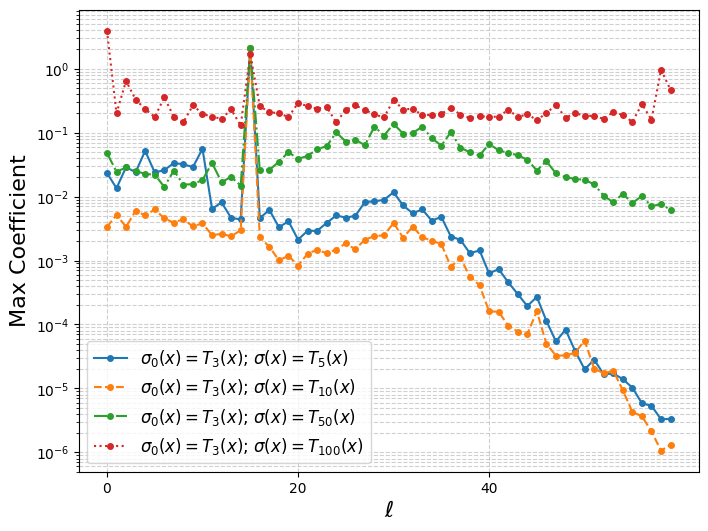

In [51]:
fig = sph.plot_max_SHT_coeffs(dict_coeffs_tcheb, ticks_l=20,)
plt.yscale("log")
plt.show()

#### SphericalSiren

In [52]:
dict_coeffs_sphsiren = {}

for w0 in w0s:

    sh_siren = sph.SphericalNet(
            L0 = 10, 
            Q = 3, 
            spectral_norm=False,
            hidden_features = 50, 
            activation =  lambda x : torch.sin(w0*x),
            first_activation = torch.sin
        )

    sph.train(
        x = X_coarse,
        y = y_coarse,
        model = sh_siren,
        loss_fn = torch.nn.MSELoss(),
        optimizer = torch.optim.Adam(sh_siren.parameters(), lr=LEARNING_RATE),
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
    )

    y_pred_fine =  torch.tensor(scaler.inverse_transform(sh_siren(X_fine).clone().detach().reshape(nlat_fine, nlon_fine)))
    coeffs_pred_fine = sht_fine(y_pred_fine).numpy()
    dict_coeffs_sphsiren[r"$\sigma_0(x) = \sin(x)$; $\sigma(x)$" +rf"$= \sin$({w0}x)"] = coeffs_pred_fine

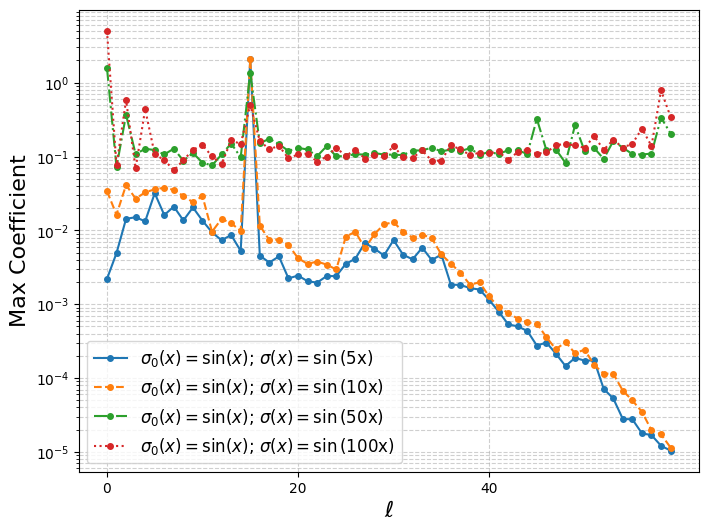

In [53]:
fig = sph.plot_max_SHT_coeffs(dict_coeffs_sphsiren, ticks_l=20)
plt.yscale("log")
plt.show()

----
## b. Study of the Impact of First Layer's Activation

This experiment fixes the hidden layer's activation function and studies how <span style="color:blue">  **varying the first layer's activation**  </span>influences the spectral properties of the reconstructed signals.


#### Parameters

**Note** :
* Same comments as before; now we are varying the first layer activation. 

In [54]:
## Spherical Net parameters
L0 = 10
Q = 3
HIDDEN_FEATURES = 50
BIAS = False


## Training parameters
EPOCHS = 1000
BATCH_SIZE = 512
LEARNING_RATE = 1e-3

## Experiment parameters
activation_degrees = [(5, 3), (10, 3), (50, 3), (100, 3), (100, 3)] # degree of the tcheby activation function
w0s_first = [5, 10, 50, 100, 100] # first activation of spherical siren is sin(w0*x)
alphas =  [(2, 3), (2, 3), (2, 3), (2, 3), (2, 3)]

#### Spherical Network with Tchebychev

In [55]:
dict_coeffs_tcheb = {}
torch.manual_seed(42)

for (degree_first, degree_subseq), (alpha_first, alpha_subseq) in zip(activation_degrees, alphas):
    # theoretical expansion = 5 * alpha ** (2)

    sh_siren = sph.SphericalNet(
         L0 = L0, 
         Q = Q, 
         hidden_features = HIDDEN_FEATURES, 
         spectral_norm=True,
         bias = BIAS, 
         activation = sph.Chebyshev(order = degree_subseq, alpha = alpha_first),
         first_activation = sph.Chebyshev(order = degree_first, alpha = alpha_subseq)
    )

    sph.train(
        x = X_coarse,
        y = y_coarse,
        model = sh_siren,
        loss_fn = torch.nn.MSELoss(),
        optimizer = torch.optim.Adam(sh_siren.parameters(), lr=LEARNING_RATE),
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
    )


    y_pred_fine = torch.tensor(scaler.inverse_transform(sh_siren(X_fine).clone().detach().reshape(nlat_fine, nlon_fine)))
    
    coeffs_pred_fine = sht_fine(y_pred_fine).numpy()
    dict_coeffs_tcheb[r"$\sigma_0(x) = T_{%.d}(x)$; $\sigma(x) = T_{%.d}(x) $"%(degree_first, degree_subseq)] = coeffs_pred_fine

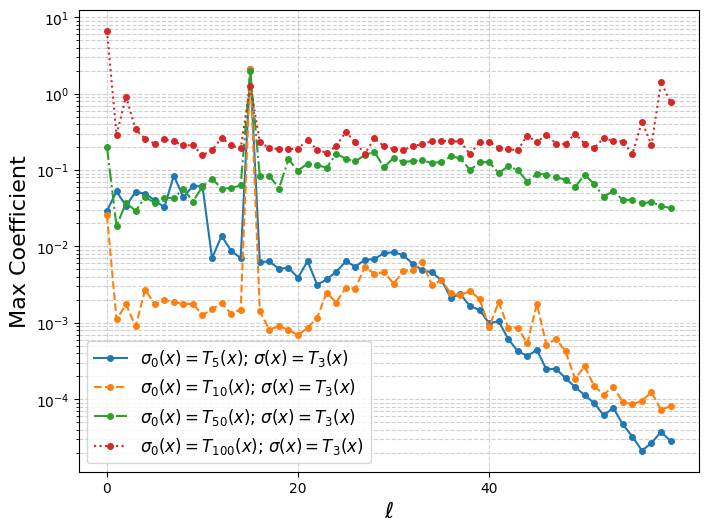

In [ ]:
fig = sph.plot_max_SHT_coeffs(dict_coeffs_tcheb, ticks_l=20,)
plt.yscale("log")
plt.show()

#### SphericalSiren

In [57]:
dict_coeffs_sphsiren = {}

for w0 in w0s_first:

    sh_siren = sph.SphericalNet(
            L0 = L0, 
            Q = Q, 
            spectral_norm=False,
            hidden_features = HIDDEN_FEATURES, 
            activation =  torch.sin,
            first_activation = lambda x : torch.sin(w0*x)
        )

    sph.train(
        x = X_coarse,
        y = y_coarse,
        model = sh_siren,
        loss_fn = torch.nn.MSELoss(),
        optimizer = torch.optim.Adam(sh_siren.parameters(), lr=LEARNING_RATE),
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
    )

    y_pred_fine =  torch.tensor(scaler.inverse_transform(sh_siren(X_fine).clone().detach().reshape(nlat_fine, nlon_fine)))
    coeffs_pred_fine = sht_fine(y_pred_fine).numpy()
    dict_coeffs_sphsiren[rf"$\sigma_0(x) = \sin(${w0}x)"+"; $\sigma(x)$" +r"$= \sin(x)$"] = coeffs_pred_fine

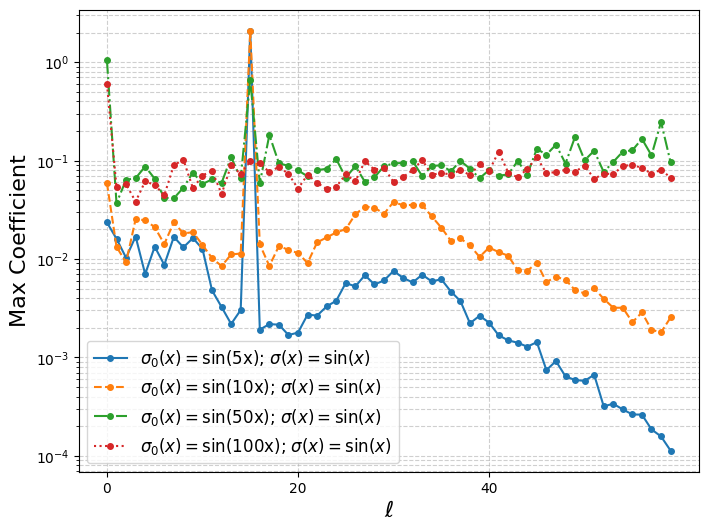

In [58]:
fig = sph.plot_max_SHT_coeffs(dict_coeffs_sphsiren, ticks_l=20)
plt.yscale("log")
plt.show()

---
### c. Study of the impact of the embedding maximum frequency $L_0$

This experiment examines how the  <span style="color:blue">  **maximum frequency $L_0$**  </span> used in the spherical embedding influences the spectral properties of the reconstructed signals.


#### Parameters

**Note** :
* We fix the activation functions parameter : 
    * Spherical Net with Tchebychev : $\sigma(x) = T_3(x)$ for all layers
    * SphericalSiren : $\sigma_0(x) = \sin(5x)$ and $\sigma(x) = \sin(x)$

In [66]:
## Spherical Net parameters
Q = 3
HIDDEN_FEATURES = 50
ACTIVATIONS_DEGREE = 3
SUPPORT = 1.0 # equi-osciation support of the activation function [-SUPP, SUPP]
W0 = 5
BIAS = False


## Training parameters
EPOCHS = 1000
BATCH_SIZE = 512
LEARNING_RATE = 1e-3

## Experiment parameters
L0s = [5, 10, 20, 25]


#### Spherical Network with Tchebychev

In [67]:
dict_coeffs_tcheb = {}
torch.manual_seed(42)

for l0 in L0s:
    # theoretical expansion = 5 * alpha ** (2)

    sh_siren = sph.SphericalNet(
         L0 = l0, 
         Q = Q, 
         hidden_features = HIDDEN_FEATURES, 
         spectral_norm=True,
         bias = BIAS, 
         activation = sph.Chebyshev(order = ACTIVATIONS_DEGREE, alpha = SUPPORT),
    )

    sph.train(
        x = X_coarse,
        y = y_coarse,
        model = sh_siren,   
        loss_fn = torch.nn.MSELoss(),
        optimizer = torch.optim.Adam(sh_siren.parameters(), lr=LEARNING_RATE),
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
    )


    y_pred_fine = torch.tensor(scaler.inverse_transform(sh_siren(X_fine).clone().detach().reshape(nlat_fine, nlon_fine)))
    
    coeffs_pred_fine = sht_fine(y_pred_fine).numpy()
    dict_coeffs_tcheb[r"$L_0 = %d$" % l0] = coeffs_pred_fine

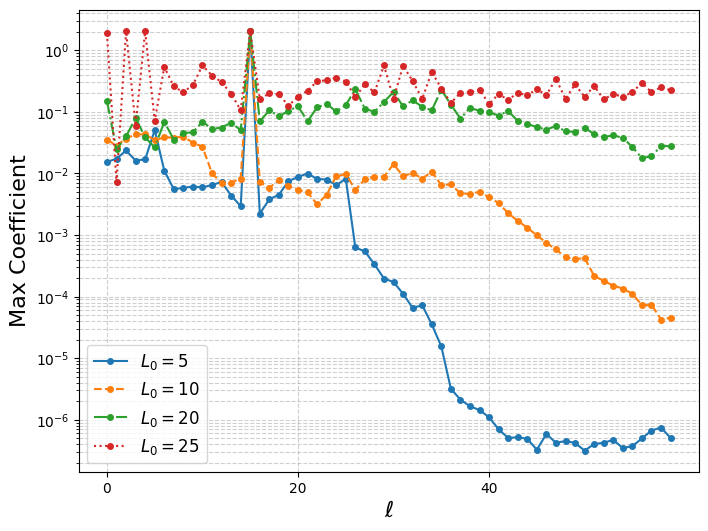

In [68]:
fig = sph.plot_max_SHT_coeffs(dict_coeffs_tcheb, ticks_l=20,)
plt.yscale("log")
plt.show()

#### SphericalSiren

In [69]:
dict_coeffs_sphsiren = {}

for l0 in L0s:

    sh_siren = sph.SphericalNet(
            L0 = l0, 
            Q = Q, 
            spectral_norm=False,
            hidden_features = HIDDEN_FEATURES, 
            activation =  torch.sin,
            first_activation = lambda x: torch.sin(W0*x)
        )

    sph.train(
        x = X_coarse,
        y = y_coarse,
        model = sh_siren,
        loss_fn = torch.nn.MSELoss(),
        optimizer = torch.optim.Adam(sh_siren.parameters(), lr=LEARNING_RATE),
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
    )

    y_pred_fine =  torch.tensor(scaler.inverse_transform(sh_siren(X_fine).clone().detach().reshape(nlat_fine, nlon_fine)))
    coeffs_pred_fine = sht_fine(y_pred_fine).numpy()
    dict_coeffs_sphsiren[r"$L_0 = %d$" % l0] = coeffs_pred_fine

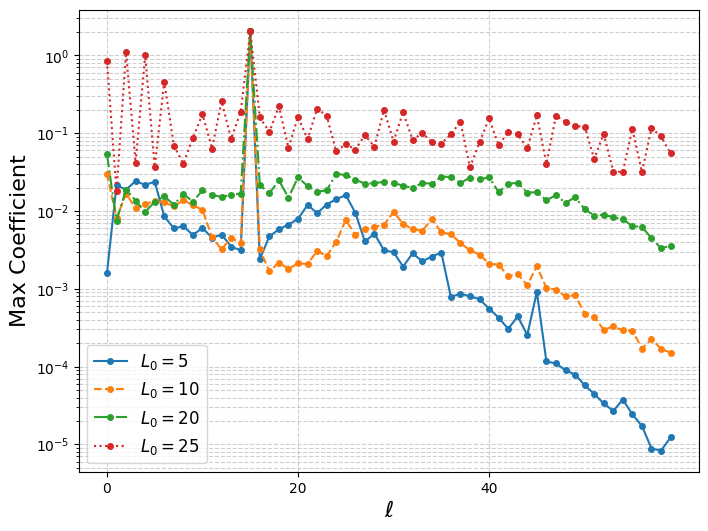

In [70]:
fig = sph.plot_max_SHT_coeffs(dict_coeffs_sphsiren, ticks_l=20)
plt.yscale("log")
plt.show()